In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = pd.read_csv('reviews.csv')
print(df.columns)


sentences = df['Sentence'].tolist()
aspects = df['Aspects'].tolist()


labels = [1] * len(sentences)

# Function to preprocess the data
def preprocess(sentences, aspects, labels):
    input_ids = []
    attention_masks = []
    label_list = []

    for sentence, aspect, label in zip(sentences, aspects, labels):
        # Construct the input text as "[CLS] sentence [SEP] aspect [SEP]"
        encoded = tokenizer(
            f"[CLS] {sentence} [SEP] {aspect} [SEP]",
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
        label_list.append(label)

    return torch.stack(input_ids), torch.stack(attention_masks), torch.tensor(label_list)

input_ids, attention_masks, labels = preprocess(sentences, aspects, labels)

# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust batch size if needed


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

#  optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(dataloader) * 4  # Assume 4 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# loss function
loss_fn = nn.CrossEntropyLoss()

# Training
epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]

        model.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_train_loss:.4f}")

# Save the fine-tuned model
model.save_pretrained("fine_tuned_bert_absa")

# Evaluation (example, add a validation set for better evaluation)
model.eval()
with torch.no_grad():
    for batch in dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        print("Predictions:", predictions)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Index(['Sentence', 'Aspects'], dtype='object')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.3459
Epoch 2, Loss: 0.0900
Epoch 3, Loss: 0.0505
Epoch 4, Loss: 0.0414
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1])


Epoch 1, Training Loss: 0.0407, Validation Loss: 0.0376
Epoch 2, Training Loss: 0.0413, Validation Loss: 0.0377
Epoch 3, Training Loss: 0.0407, Validation Loss: 0.0377
Epoch 4, Training Loss: 0.0400, Validation Loss: 0.0376


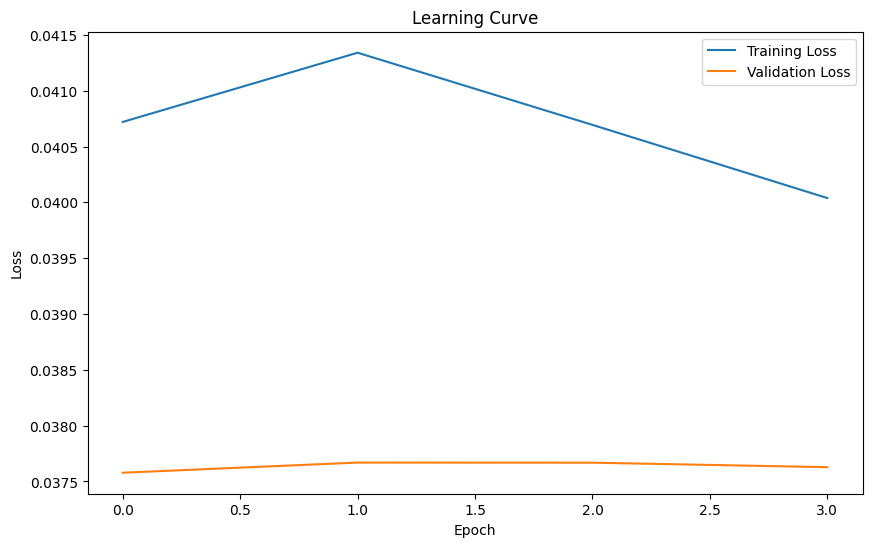

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
F2 Score: 1.0000


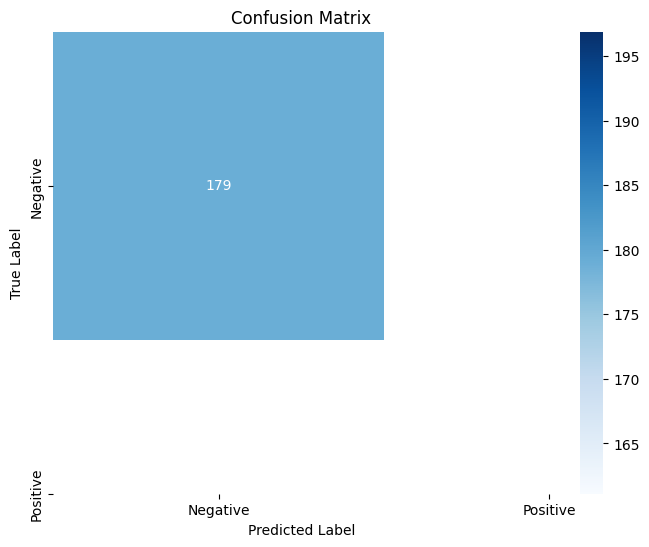

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
import numpy as np
import seaborn as sns

# Placeholder for storing training and validation loss
train_losses = []
val_losses = []

# Training loop with validation
epochs = 4
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]

        model.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader)
    train_losses.append(avg_train_loss)

    # Validation phase (using the same DataLoader for simplicity; ideally, use a separate validation set)
    model.eval()
    total_val_loss = 0
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            val_predictions.extend(predictions)
            val_labels.extend(batch_labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Confusion Matrix and Metrics
conf_matrix = confusion_matrix(val_labels, val_predictions)
accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')

# F2 Score
def fbeta_score(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

f2 = fbeta_score(val_labels, val_predictions, beta=2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
